In [2]:
import pandas as pd
import numpy as np
from scipy. stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('habr_data_3.csv')

In [4]:
df.shape

(1000, 9)

In [5]:
df.head()

,item name,Время чтения,Сложность,Количество просмотров,В закладках,Комментарии,Автор,Рейтинг автора,Время публикации
0,Мультяшная графика продаётся лучше реалистично...,8,2,324,1,1,@Kallist,0.0,"2023-05-13, 19:20"
1,Picture in Picture Mode в android. Показываем ...,5,1,122,3,0,@cookie2727,0.0,"2023-05-13, 18:55"
2,"Много нас, а GPU один. Как делиться?",6,1,1600,5,6,@Antra,6.1,"2023-05-13, 17:57"
3,Ближайшие бесплатные мероприятия по разработке...,2,1,376,1,0,@ITMeeting,-0.8,"2023-05-13, 16:27"
4,Одноплатник Orange Pi 5 Plus: характеристики и...,4,",",3500,6,13,@Seleditor,49.0,"2023-05-13, 12:55"


Получим общее представление о наших данных: посмотрим на описательные статистики, поищем тенденции для некоторых колонок

In [6]:
df.describe().round(decimals=0)

,Время чтения,Количество просмотров,В закладках,Комментарии,Рейтинг автора
count,1000.0,1000.0,1000.0,1000.0,996.0
mean,9.0,5345.0,35.0,16.0,42.0
std,7.0,8175.0,37.0,40.0,87.0
min,1.0,122.0,0.0,0.0,-24.0
25%,5.0,1600.0,13.0,1.0,4.0
50%,7.0,2900.0,23.0,5.0,13.0
75%,10.0,5600.0,44.0,14.0,39.0
max,84.0,94000.0,322.0,703.0,657.0


In [7]:
df.describe(include='object')

,item name,Сложность,Автор,Время публикации
count,1000,1000,996,1000
unique,1000,4,706,971
top,Мультяшная графика продаётся лучше реалистично...,1,@MaxRokatansky,"2023-04-13, 13:41"
freq,1,370,27,2


In [8]:
df['Сложность'].value_counts()

1    370
,    314
2    280
3     36
Name: Сложность, dtype: int64

In [9]:
df['Автор'].value_counts().head()

@MaxRokatansky     27
@ph_piter          11
@ru_vds            11
@rikki_tikki        9
@dmitriizolotov     7
Name: Автор, dtype: int64

+ наглядно изобразим, как распределены данные, используя гистограммы

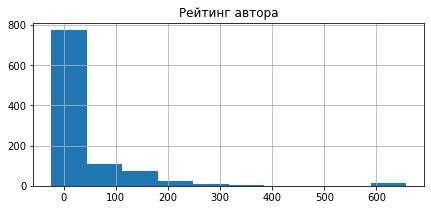

In [10]:
df['Рейтинг автора'].hist(figsize=(7, 3)).set_title('Рейтинг автора');

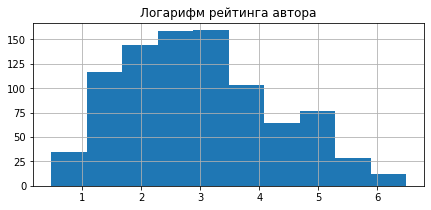

In [11]:
pos = df['Рейтинг автора'] > 0

df['Рейтинг автора'][(pos)].apply(lambda x: np.log(x + 1)).hist(figsize=(7, 3)).set_title('Логарифм рейтинга автора');

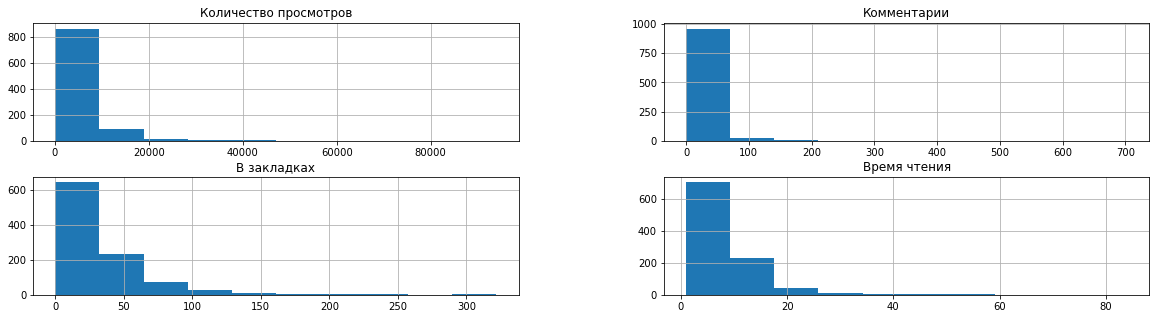

In [12]:
columns = ['Количество просмотров', 'Комментарии', 'В закладках', 'Время чтения']
df[columns].hist(figsize=(20, 5));

In [14]:
columns = ['Количество просмотров', 'Комментарии', 'В закладках', 'Время чтения']
df[columns].median()

Количество просмотров    2900.0
Комментарии                 5.0
В закладках                23.0
Время чтения                7.0
dtype: float64

На следующих гистограммах видим, что распределение числа просмотров и сохранений близко к нормальному, время чтения также стремится к нормальному, хотя есть выбросы в виде очень больших значений времени чтения.

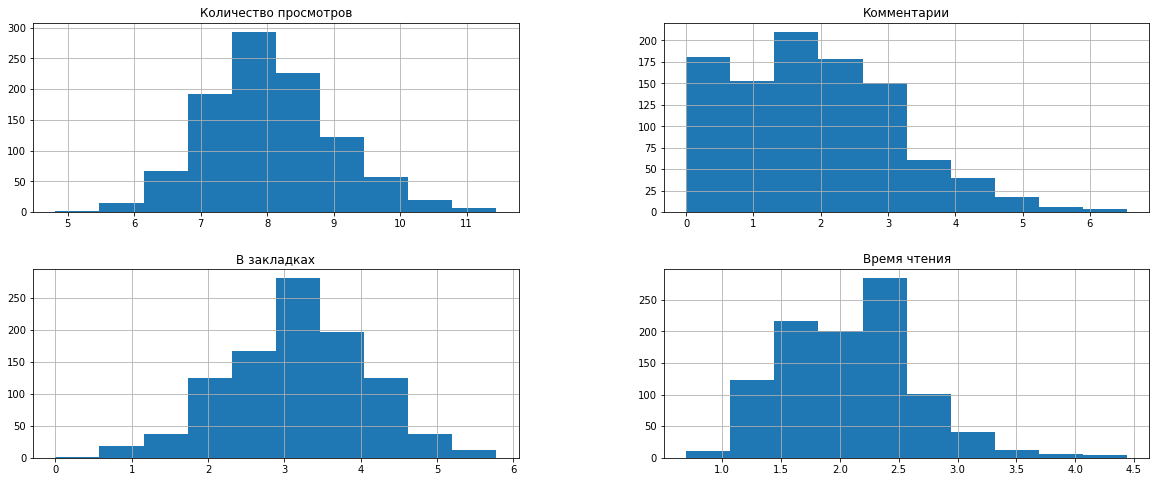

In [51]:
df[columns].apply(lambda x: np.log(x + 1)).hist(figsize=(20, 8))
plt.show()

Оценим количество выбросов в этих переменных (будет важно для дальнейшего машинного обучения)

<AxesSubplot:>

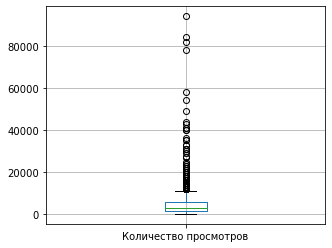

In [49]:
df.boxplot(['Количество просмотров'], figsize=(5, 4))

In [ ]:
df[['Количество просмотров']]

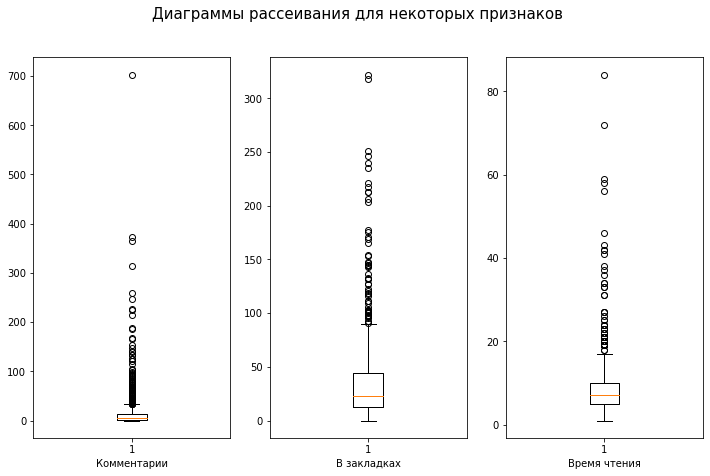

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 7))
fig.suptitle('Диаграммы рассеивания для некоторых признаков', fontsize=15)
axes[0].boxplot(df['Комментарии'])
axes[0].set_xlabel('Комментарии')
axes[1].boxplot(df['В закладках'])
axes[1].set_xlabel('В закладках')
axes[2].boxplot(df['Время чтения'])
axes[2].set_xlabel('Время чтения');

Выбросы не ошибочны/случайны, вполне объяснимы: в выборке из постов за определенный промежуток времени некоторые посты бывают очень популярны (и имеют высокие показатели просмотров, комментариев и сохранений) по сравнению с медианным/средним значением.

Судя по графику ниже, на наших данных не получается отследить изменение в рейтинге автора во времени - взяли автора с наибольшим количеством постов в датасете. Очень маленький промежуток времени, и поэтому установить связи касательно переменных, влияющих на изменение рейтинга автора, не удается.

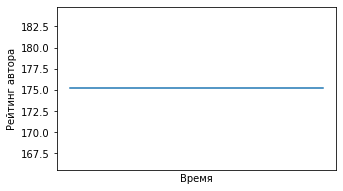

In [56]:
plt.figure(figsize=(5, 3))
x = df[(df['Автор'] == '@MaxRokatansky')]['Время публикации']
y = df[(df['Автор'] == '@MaxRokatansky')]['Рейтинг автора']
plt.plot(x, y)
plt.xticks([])
plt.xlabel('Время')
plt.ylabel('Рейтинг автора')
plt.show()

  Определяем худших авторов, хд, а условия пока следующие:

In [34]:
cond1 = df['Рейтинг автора'] < df['Количество просмотров'].mean()
cond2 = df['Количество просмотров'] < df['Количество просмотров'].mean()
df[(cond1) & (cond2)].sort_values(by='Рейтинг автора', ascending=True).head()

,item name,Время чтения,Сложность,Количество просмотров,В закладках,Комментарии,Автор,Рейтинг автора,Время публикации
340,"Гипотеза Коллатца, часть 2",4,1,3100,6,102,@Martynov_M,-24.2,"2023-05-02, 23:58"
954,«DEEPFAKE» как программа для ЭВМ — искажения р...,6,1,769,2,0,@shushpanov_official,-19.0,"2023-04-14, 14:00"
302,Telegram Bot — ваш новый помощник,4,1,3800,24,1,@shushpanov_official,-19.0,"2023-05-03, 21:24"
901,Клонирование объектов JS,5,2,2800,46,26,@Usetech,-14.0,"2023-04-17, 08:14"
515,Чего ждать разработчикам от WWDC 2023?,3,",",1700,6,2,@Usetech,-14.0,"2023-04-27, 06:10"


In [35]:
df[(df['Автор'] == '@Martynov_M')]

,item name,Время чтения,Сложность,Количество просмотров,В закладках,Комментарии,Автор,Рейтинг автора,Время публикации
340,"Гипотеза Коллатца, часть 2",4,1,3100,6,102,@Martynov_M,-24.2,"2023-05-02, 23:58"
435,"Гипотеза Коллатца, часть 1",5,1,6400,22,63,@Martynov_M,-24.2,"2023-04-28, 21:42"


    ** Для определения взаимосвязей опробуем визуализацию данных~ **

Посмотрим на характер взаимосвязи некоторых признаков с помощью диаграмм рассеивания

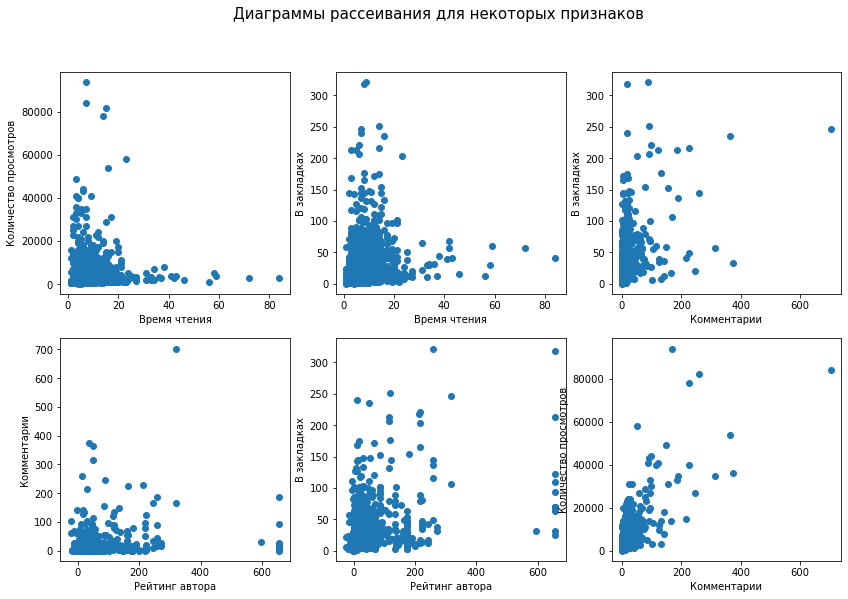

In [68]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 9))
fig.suptitle('Диаграммы рассеивания для некоторых признаков', fontsize=15)
axes[0, 0].scatter(df['Время чтения'], df['Количество просмотров'])
axes[0, 0].set_xlabel('Время чтения')
axes[0, 0].set_ylabel('Количество просмотров')

axes[0, 1].scatter(df['Время чтения'], df['В закладках'])
axes[0, 1].set_xlabel('Время чтения')
axes[0, 1].set_ylabel('В закладках')

axes[0, 2].scatter(df['Комментарии'], df['В закладках'])
axes[0, 2].set_xlabel('Комментарии')
axes[0, 2].set_ylabel('В закладках')

axes[1, 0].scatter(df['Рейтинг автора'], df['Комментарии'])
axes[1, 0].set_xlabel('Рейтинг автора')
axes[1, 0].set_ylabel('Комментарии')

axes[1, 1].scatter(df['Рейтинг автора'], df['В закладках'])
axes[1, 1].set_xlabel('Рейтинг автора')
axes[1, 1].set_ylabel('В закладках')

axes[1, 2].scatter(df['Комментарии'], df['Количество просмотров'])
axes[1, 2].set_xlabel('Комментарии')
axes[1, 2].set_ylabel('Количество просмотров')

plt.show()

Посмотрим, насколько сложность темы на данном ресурсе (если судить по имеющейся выборке) отнимает от или прибавляет к популярности статьи

In [64]:
df_ed = df[(df['Сложность'] != ',')]
df_ed.loc['Сложность'] = pd.to_numeric(df_ed['Сложность'])

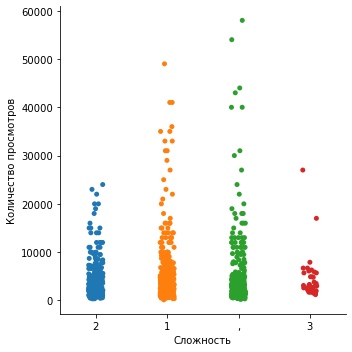

In [78]:
sns.catplot(x='Сложность', y='Количество просмотров', data=df[(df['Количество просмотров'] < 60000)]);

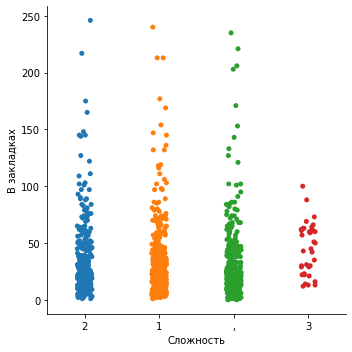

In [80]:
sns.catplot(x='Сложность', y='В закладках', data=df[(df['В закладках'] < 250)]);

Судя по ящикам с усами на графике ниже, можно предположить, что сложность текста положительно коррелирует с временем чтения текста: у наименьшей сложности меньше время чтения, чем у 2й и 3ей сложностей. В этом есть логика: более сложные темы требуют более подробного объяснения. Можем сделать допущение, что признаки Сложность и Время чтения в некотором роде повторяют друг друга,в данном наборе информации.

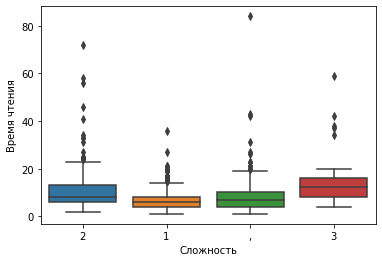

In [36]:
sns.boxplot(x=df['Сложность'], y=df['Время чтения'])
plt.xlabel('Сложность')
plt.ylabel('Время чтения');

Наглядно узнаем и сравним численные значения корреляций, а также выясним, какие переменные имеют сильную корреляцию, с помощью HeatMap

In [39]:
df.dtypes

item name                 object
Время чтения               int64
Сложность                 object
Количество просмотров      int64
В закладках                int64
Комментарии                int64
Автор                     object
Рейтинг автора           float64
Время публикации          object
dtype: object

In [42]:
colnames = df.dtypes[df.dtypes != 'object'].index.values
print(colnames)
df[colnames].corr(method='pearson')

['Время чтения' 'Количество просмотров' 'В закладках' 'Комментарии'
 'Рейтинг автора']


,Время чтения,Количество просмотров,В закладках,Комментарии,Рейтинг автора
Время чтения,1.000000,0.011362,0.116059,-0.029841,0.025547
Количество просмотров,0.011362,1.000000,0.642702,0.748384,0.329522
В закладках,0.116059,0.642702,1.000000,0.406296,0.338872
Комментарии,-0.029841,0.748384,0.406296,1.000000,0.224106
Рейтинг автора,0.025547,0.329522,0.338872,0.224106,1.000000


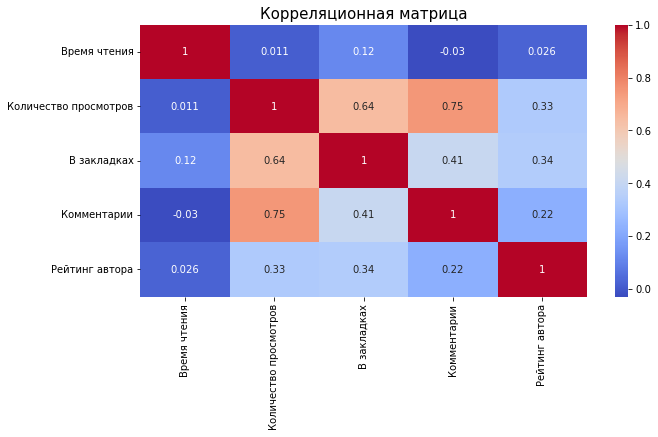

In [43]:
corr = df.corr()

plt.figure(figsize=(10,5))
plt.title('Корреляционная матрица', fontsize=15)
corrvis = sns.heatmap(corr, annot=True, cmap='coolwarm')

Проделаем то же самое для сглаженных данных - возьмем логарифмы признаков

In [45]:
df_log = df[colnames].apply(lambda x: np.log(x + 1))
df_log.head()

,Время чтения,Количество просмотров,В закладках,Комментарии,Рейтинг автора
0,2.197225,5.783825,0.693147,0.693147,0.000000
1,1.791759,4.812184,1.386294,0.000000,0.000000
2,1.945910,7.378384,1.791759,1.945910,1.960095
3,1.098612,5.932245,0.693147,0.000000,-1.609438
4,1.609438,8.160804,1.945910,2.639057,3.912023


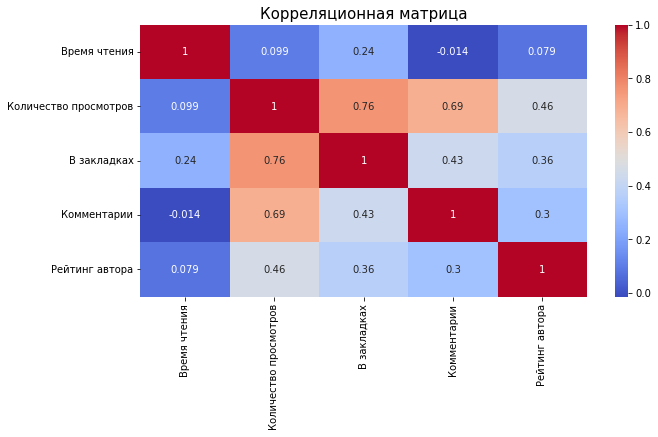

In [46]:
corr_l = df_log.corr()

plt.figure(figsize=(10,5))
plt.title('Корреляционная матрица', fontsize=15)
corrvis = sns.heatmap(corr_l, annot=True, cmap='coolwarm')

Видно, что наибольшую положительную корреляцию имеют количество просмотров и комментариев, а также просмотров и сохранений, что логично. Все это показатели активности/популярности статьи. Пока что слабая корреляция прослеживается между рейтингом автора и просмотрами/закладками/комментами (активностью). Возможно, автор не так важен для активности, как и время чтения. Осталось проверить, как влияет сложность.

Также можно сделать предположения о том, как показатели активности влияют друг на друга: на количество просмотров могут влиять выраженная в сохранениях полезность статьи, побуждающая делиться постом. А если количество просмотров неслабо связано с комментариями, значит, на хабре сидят очень активные и любящие обсуждение пользователи, что похоже на правду~